In [4]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np


In [9]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

In [10]:
data_set = []
for i in range (1, 10):
    data_set.append(load_images_from_folder("ACdata_base/" + str(i)))


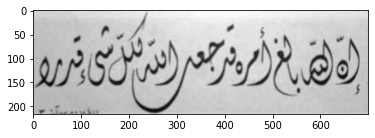

[[189 189 190 ... 197 196 195]
 [188 188 189 ... 197 196 195]
 [186 187 188 ... 197 196 195]
 ...
 [172 175 178 ... 182 181 180]
 [173 175 179 ... 183 183 182]
 [173 176 179 ... 184 183 182]]


In [12]:
plt.imshow(data_set[0][0],cmap='gray')
plt.show()